In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [2]:
# Read raw datasets
meningitis_raw = pd.read_csv('/kaggle/input/meningitis/full_encoded_meningitis.csv')
nonmeningitis_raw = pd.read_csv('/kaggle/input/meningitis/full_encoded_non_meningitis.xls')

<h2 style="color: yellow;">Elimiate Columns that directly indicate meningits</h2>
<p style="color: yellow;">We excluded columns starting with '32' that directly indicate meningitis, since they would entail data leaking</p>

In [3]:
# Check whether there are meningitis related columns (starting with '32') in Meningitis dataset
print("Checking for columns starting with '32' in meningitis_raw...")
print("="*60)

# Get all column names
all_columns_men = meningitis_raw.columns.tolist()

# Find columns that start with "32"
columns_starting_32_men = [col for col in all_columns_men if str(col).startswith(('320','321','322'))]

print(f"Total columns in dataset: {len(all_columns_men)}")
print(f"Columns starting with '32': {len(columns_starting_32_men)}")
print()

if columns_starting_32_men:
    print("Found columns starting with '32':")
    print("-" * 40)
    
    # Sort the columns for better readability
    columns_starting_32_sorted_men = sorted(columns_starting_32_men)
    
    for i, col in enumerate(columns_starting_32_sorted_men, 1):
        # Check how many patients have this code
        count = meningitis_raw[col].sum() if col in meningitis_raw.columns else 0
        percentage = (count / len(meningitis_raw)) * 100 if len(meningitis_raw) > 0 else 0
        
        # Check positive rate when this code is present
        if count > 0:
            pos_rate = meningitis_raw[meningitis_raw[col] == 1]['CLASSIFIER'].mean()
        else:
            pos_rate = 0
            
        print(f"{i:2d}. {str(col):<8} - Present in {int(count):4d} patients ({percentage:5.2f}%) - Pos rate: {pos_rate:.3f}")
    
    print()
    print("Detailed analysis of '32' codes:")
    print("-" * 50)
    
    # Group by length for better understanding
    length_groups = {}
    for col in columns_starting_32_sorted_men:
        length = len(str(col))
        if length not in length_groups:
            length_groups[length] = []
        length_groups[length].append(col)
    
    for length in sorted(length_groups.keys()):
        print(f"\nLength {length} codes ({len(length_groups[length])} codes):")
        for col in length_groups[length]:
            count = int(meningitis_raw[col].sum())
            percentage = (count / len(meningitis_raw)) * 100
            if count > 0:
                pos_rate = meningitis_raw[meningitis_raw[col] == 1]['CLASSIFIER'].mean()
                print(f"  {str(col)}: {count} patients ({percentage:.2f}%) - Meningitis rate: {pos_rate:.3f}")
            else:
                print(f"  {str(col)}: {count} patients ({percentage:.2f}%) - No patients with this code")

Checking for columns starting with '32' in meningitis_raw...
Total columns in dataset: 983
Columns starting with '32': 14

Found columns starting with '32':
----------------------------------------
 1. 3200     - Present in    2 patients ( 0.93%) - Pos rate: 1.000
 2. 3201     - Present in   13 patients ( 6.07%) - Pos rate: 1.000
 3. 3202     - Present in   16 patients ( 7.48%) - Pos rate: 1.000
 4. 3203     - Present in   26 patients (12.15%) - Pos rate: 1.000
 5. 3207     - Present in    7 patients ( 3.27%) - Pos rate: 1.000
 6. 32082    - Present in   23 patients (10.75%) - Pos rate: 1.000
 7. 32089    - Present in    3 patients ( 1.40%) - Pos rate: 1.000
 8. 3209     - Present in   24 patients (11.21%) - Pos rate: 1.000
 9. 3210     - Present in    6 patients ( 2.80%) - Pos rate: 1.000
10. 3212     - Present in    1 patients ( 0.47%) - Pos rate: 1.000
11. 3220     - Present in    5 patients ( 2.34%) - Pos rate: 1.000
12. 3221     - Present in    1 patients ( 0.47%) - Pos rate: 1.00

In [4]:
# Check whether there are meningitis related columns (starting with '32') in non-meningitis dataset
print("Checking for columns starting with '32' in nonmeningitis_raw...")
print("="*60)

# Get all column names
all_columns_nonmen = nonmeningitis_raw.columns.tolist()

# Find columns that start with "32"
columns_starting_32_nonmen = [col for col in all_columns_nonmen if str(col).startswith(('320','321','322'))]

print(f"Total columns in dataset: {len(all_columns_nonmen)}")
print(f"Columns starting with '32': {len(columns_starting_32_nonmen)}")
print()

if columns_starting_32_nonmen:
    print("Found columns starting with '32':")
    print("-" * 40)
    
    # Sort the columns for better readability
    columns_starting_32_sorted_nonmen = sorted(columns_starting_32_nonmen)
    
    for i, col in enumerate(columns_starting_32_sorted_nonmen, 1):
        # Check how many patients have this code
        count = nonmeningitis_raw[col].sum() if col in nonmeningitis_raw.columns else 0
        percentage = (count / len(nonmeningitis_raw)) * 100 if len(nonmeningitis_raw) > 0 else 0
        
        # Check positive rate when this code is present
        if count > 0:
            pos_rate = nonmeningitis_raw[nonmeningitis_raw[col] == 1]['CLASSIFIER'].mean()
        else:
            pos_rate = 0
            
        print(f"{i:2d}. {str(col):<8} - Present in {int(count):4d} patients ({percentage:5.2f}%) - Pos rate: {pos_rate:.3f}")
    
    print()
    print("Detailed analysis of '32' codes:")
    print("-" * 50)
    
    # Group by length for better understanding
    length_groups = {}
    for col in columns_starting_32_sorted_nonmen:
        length = len(str(col))
        if length not in length_groups:
            length_groups[length] = []
        length_groups[length].append(col)
    
    for length in sorted(length_groups.keys()):
        print(f"\nLength {length} codes ({len(length_groups[length])} codes):")
        for col in length_groups[length]:
            count = int(nonmeningitis_raw[col].sum())
            percentage = (count / len(nonmeningitis_raw)) * 100
            if count > 0:
                pos_rate = nonmeningitis_raw[nonmeningitis_raw[col] == 1]['CLASSIFIER'].mean()
                print(f"  {str(col)}: {count} patients ({percentage:.2f}%) - Meningitis rate: {pos_rate:.3f}")
            else:
                print(f"  {str(col)}: {count} patients ({percentage:.2f}%) - No patients with this code")

Checking for columns starting with '32' in nonmeningitis_raw...
Total columns in dataset: 6962
Columns starting with '32': 0



In [5]:
# # Create new dataset without meningitis code columns
meningitis_clean = meningitis_raw.drop(columns=columns_starting_32_men)

In [6]:
# Check columns that start with "('320','321','322')"
all_columns_clean_men = meningitis_clean.columns.tolist()

columns_starting_32_clean = [col for col in all_columns_clean_men if str(col).startswith(('320','321','322'))]

print(f"Total columns in dataset: {len(all_columns_clean_men)}")
print(f"Columns starting with '('320','321','322')': {len(columns_starting_32_clean)}")
print()

Total columns in dataset: 969
Columns starting with '('320','321','322')': 0



In [7]:
(nonmeningitis_raw["CLASSIFIER"] == 1).any()

False

In [8]:
print(meningitis_clean.shape)
print(nonmeningitis_raw.shape)
print(meningitis_clean.head)
print(nonmeningitis_raw.head)

(214, 969)
(46303, 6962)
<bound method NDFrame.head of      SUBJECT_ID  GENDER  00845  0090  0270  0362  0380  03811  03812  03819  \
0         10144       0      0     0     0     0     0      0      1      0   
1         10316       1      0     0     0     0     0      0      0      0   
2         10361       0      1     0     0     0     0      0      0      0   
3         10614       1      0     0     0     0     0      0      0      0   
4         11093       0      0     0     0     0     0      0      0      0   
..          ...     ...    ...   ...   ...   ...   ...    ...    ...    ...   
209         994       0      0     0     0     0     0      0      0      0   
210        9971       0      0     0     0     0     0      0      0      0   
211       99776       1      0     0     0     0     0      0      0      0   
212        9981       0      0     0     0     0     0      0      0      0   
213       99957       1      0     0     0     0     0      0      0      0 

In [9]:
# Ramdonly extract 180 samples for training set and 34 samples for testing set in meningitis cohort
men_180 = meningitis_clean.sample(n=180, random_state=42)
men_34 = meningitis_clean.drop(men_180.index)

In [10]:
print(men_180.head)
print(men_34.head)

<bound method NDFrame.head of      SUBJECT_ID  GENDER  00845  0090  0270  0362  0380  03811  03812  03819  \
9          1241       1      0     0     0     0     0      0      0      0   
197       87279       1      0     0     0     0     0      0      0      0   
66        25995       1      0     0     0     0     0      0      0      0   
191       83132       1      0     0     0     0     0      0      0      0   
117       48876       0      1     0     0     0     0      0      0      0   
..          ...     ...    ...   ...   ...   ...   ...    ...    ...    ...   
54        23385       1      0     0     0     0     0      0      0      0   
107       44793       0      0     0     0     0     0      0      0      0   
50        22894       0      0     0     0     0     0      0      0      0   
174        7466       1      0     0     0     0     0      0      0      0   
210        9971       0      0     0     0     0     0      0      0      0   

     ...  V600  V602 

In [11]:
# Ramdonly extract 38955 samples for training set and 7348 samples for testing set in the non-meningitis cohort
non_men_38955 = nonmeningitis_raw.sample(n=38955, random_state=42)
non_men_7348 = nonmeningitis_raw.drop(non_men_38955.index)

In [12]:
# Ramdonly extract 180 and 8000 samples for training set in the non-meningitis cohort
non_men_180 = non_men_38955.sample(n=180, random_state=42)
non_men_8000 = non_men_38955.sample(n=8000, random_state=42)

In [13]:
print(non_men_38955.head)
print(non_men_7348.head)

<bound method NDFrame.head of        SUBJECT_ID  GENDER  0030  0031  0038  0039  0041  0048  0049  0051  \
27088       47410       1     0     0     0     0     0     0     0     0   
36936       74284       1     0     0     0     0     0     0     0     0   
35360       69781       1     0     0     0     0     0     0     0     0   
40875        8507       0     0     0     0     0     0     0     0     0   
29586       54172       1     0     0     0     0     0     0     0     0   
...           ...     ...   ...   ...   ...   ...   ...   ...   ...   ...   
27370       48149       1     0     0     0     0     0     0     0     0   
8399        18031       1     0     0     0     0     0     0     0     0   
9079        18692       0     0     0     0     0     0     0     0     0   
524         10495       0     0     0     0     0     0     0     0     0   
42392        8930       1     0     0     0     0     0     0     0     0   

       ...  V8811  V8812  V8821  V9010  V902 

In [14]:
# Combine data for training set and testing set
training_combined = pd.concat([men_180, non_men_38955], ignore_index = True)

# Combine data for training set of 360 and 8000 samples
# Note: This is a separate training set with only 360 and 8000 samples from the non-meningitis cohort
# This is useful for testing purposes or small-scale experiments
training_combined_360 = pd.concat([men_180, non_men_180], ignore_index = True)
training_combined_8180 = pd.concat([men_180, non_men_8000], ignore_index = True)

In [15]:
# Combine multiple testing sets
testing_combined_7382 = pd.concat([men_34, non_men_7348], ignore_index = True)

In [16]:
# Drop SUBJECT_ID of training sets
training_ID_Drop = training_combined.drop('SUBJECT_ID', axis = 1)
training_ID_Drop_360 = training_combined_360.drop('SUBJECT_ID', axis = 1)
training_ID_Drop_8180 = training_combined_8180.drop('SUBJECT_ID', axis = 1)

# Drop SUBJECT_ID of testing sets
testing_ID_Drop_7382 = testing_combined_7382.drop('SUBJECT_ID', axis = 1)

In [17]:
# Shuffle the training datasets to ensure random distribution
training_shuffled = training_ID_Drop.sample(frac=1, random_state=42).reset_index(drop=True)
training_shuffled_360 = training_ID_Drop_360.sample(frac=1, random_state=42).reset_index(drop=True)
training_shuffled_8180 = training_ID_Drop_8180.sample(frac=1, random_state=42).reset_index(drop=True)

# Shuffle the testing datasets to ensure random distribution
testing_shuffled_7382 = testing_ID_Drop_7382.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
print(training_shuffled.shape)
print(training_shuffled_360.shape)
print(training_shuffled_8180.shape)

print(testing_shuffled_7382.shape)

(39135, 6970)
(360, 6970)
(8180, 6970)
(7382, 6970)


In [19]:
# Check for NaN values in each dataset
print("NaN values in training data:\n", training_shuffled.isnull().sum())
print("\n" + "NaN values in training data (360 samples):\n", training_shuffled_360.isnull().sum())
print("\n" + "NaN values in training data (8180 samples):\n", training_shuffled_8180.isnull().sum())

print("\n" + "NaN values in testing data with 7382 samples:\n", testing_shuffled_7382.isnull().sum())

NaN values in training data:
 GENDER      0
00845       0
0090        0
0270        0
0362        0
         ... 
V902      180
V9039     180
V9081     180
V9089     180
V9103     180
Length: 6970, dtype: int64

NaN values in training data (360 samples):
 GENDER      0
00845       0
0090        0
0270        0
0362        0
         ... 
V902      180
V9039     180
V9081     180
V9089     180
V9103     180
Length: 6970, dtype: int64

NaN values in training data (8180 samples):
 GENDER      0
00845       0
0090        0
0270        0
0362        0
         ... 
V902      180
V9039     180
V9081     180
V9089     180
V9103     180
Length: 6970, dtype: int64

NaN values in testing data with 7382 samples:
 GENDER     0
00845      0
0090       0
0270       0
0362       0
          ..
V902      34
V9039     34
V9081     34
V9089     34
V9103     34
Length: 6970, dtype: int64


In [20]:
# Replace NaN values with 0 in each dataset
df_training = training_shuffled.fillna(0)
df_testing_7382 = testing_shuffled_7382.fillna(0)
df_training_360 = training_shuffled_360.fillna(0)
df_training_8180 = training_shuffled_8180.fillna(0)

# Verify if NaN values are replaced
print("NaN values in df_training:\n", df_training.isnull().sum())
print("\nNaN values in df_testing:\n", df_testing_7382.isnull().sum())
print("\nNaN values in df_training_180:\n", df_training_360.isnull().sum())
print("\nNaN values in df_training_8000:\n", df_training_8180.isnull().sum())

NaN values in df_training:
 GENDER    0
00845     0
0090      0
0270      0
0362      0
         ..
V902      0
V9039     0
V9081     0
V9089     0
V9103     0
Length: 6970, dtype: int64

NaN values in df_testing:
 GENDER    0
00845     0
0090      0
0270      0
0362      0
         ..
V902      0
V9039     0
V9081     0
V9089     0
V9103     0
Length: 6970, dtype: int64

NaN values in df_training_180:
 GENDER    0
00845     0
0090      0
0270      0
0362      0
         ..
V902      0
V9039     0
V9081     0
V9089     0
V9103     0
Length: 6970, dtype: int64

NaN values in df_training_8000:
 GENDER    0
00845     0
0090      0
0270      0
0362      0
         ..
V902      0
V9039     0
V9081     0
V9089     0
V9103     0
Length: 6970, dtype: int64


In [21]:
# Check duplicate column names in training data
duplicate_columns = df_training_360.columns[df_training_360.columns.duplicated()].unique()
print(duplicate_columns)

Index([], dtype='object')


In [22]:
#################################################################################

<h2 style="color: yellow;">Conduct Feature Importance</h2>
<p style="color: yellow;">1. Find out features that are most related to meningitis;<br> 2. A simulated situation in ER that includes 50% non-meningitis cases is needed. To this end, we search samples in negative samples where each one has at least 10 similar features extracted from top 100.</p>

In [23]:
# Separate features and labels
X = df_training.drop('CLASSIFIER', axis=1)
y = df_training['CLASSIFIER']

print("Class distribution:")
print(y.value_counts())
print(f"Positive class ratio: {y.mean():.4f}")
print()

Class distribution:
CLASSIFIER
0    38955
1      180
Name: count, dtype: int64
Positive class ratio: 0.0046



In [24]:
# Train Random Forest for feature importance
print("Training Random Forest for feature importance...")
rf_importance = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

rf_importance.fit(X, y)

Training Random Forest for feature importance...


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [25]:
# Get feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

In [26]:
print(feature_importance_df.head(100))

    feature  importance
338   41401    0.029788
232    3314    0.023201
373     430    0.018300
809   99663    0.015618
712   78039    0.014837
..      ...         ...
386    4373    0.002293
30      042    0.002284
631   73300    0.002279
895   V1011    0.002256
38     0549    0.002236

[100 rows x 2 columns]


In [27]:
print("Top 100 most important features:")
print("-" * 50)
for i, (idx, row) in enumerate(feature_importance_df.head(100).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:8s} : {row['importance']:.6f}")

print("/n" + "Feature importance distribution:")
print(f"Max importance: {feature_importance_df['importance'].max():.6f}")
print(f"Mean importance: {feature_importance_df['importance'].mean():.6f}")
print(f"Min importance: {feature_importance_df['importance'].min():.6f}")
print(f"Features with importance > 0.001: {(feature_importance_df['importance'] > 0.001).sum()}")

Top 100 most important features:
--------------------------------------------------
 1. 41401    : 0.029788
 2. 3314     : 0.023201
 3. 430      : 0.018300
 4. 99663    : 0.015618
 5. 78039    : 0.014837
 6. 431      : 0.014136
 7. V290     : 0.013691
 8. GENDER   : 0.010588
 9. V053     : 0.010376
10. 42731    : 0.009854
11. 7907     : 0.009410
12. 51881    : 0.009336
13. 4019     : 0.009102
14. 2761     : 0.008943
15. 4280     : 0.006816
16. 77181    : 0.006478
17. 2724     : 0.006309
18. 5849     : 0.006135
19. 769      : 0.005922
20. 3453     : 0.005913
21. 7766     : 0.005811
22. 53081    : 0.005757
23. 99592    : 0.005752
24. 3829     : 0.005682
25. 25000    : 0.005658
26. 3240     : 0.005648
27. 08881    : 0.005647
28. 496      : 0.005627
29. 03811    : 0.005466
30. 2760     : 0.005284
31. 3510     : 0.005192
32. 5990     : 0.005135
33. 486      : 0.005135
34. 5070     : 0.005093
35. 3488     : 0.004830
36. 99859    : 0.004802
37. 1175     : 0.004713
38. 2449     : 0.004698
39. 

In [28]:
# Select top 100 features
top_100_features = feature_importance_df.head(100)['feature'].tolist()

print("Top 100 most important features selected:")
print(f"Feature importance range: {top_100_features[0]} ({feature_importance_df.iloc[0]['importance']:.6f}) to {top_100_features[99]} ({feature_importance_df.iloc[99]['importance']:.6f})")
print()

Top 100 most important features selected:
Feature importance range: 41401 (0.029788) to 0549 (0.002236)



In [29]:
# Create new training dataset with top 50 features + target
df_training_important = df_training[top_100_features + ['CLASSIFIER']].copy()

print("New dataset created: df_training_important")
print(f"New dataset shape: {df_training_important.shape}")
print(f"Features reduced from {X.shape[1]} to {len(top_100_features)}")
print()

New dataset created: df_training_important
New dataset shape: (39135, 101)
Features reduced from 6969 to 100



In [30]:
# Verify the selection worked correctly
print("Verification:")
print(f"All features present: {set(top_100_features).issubset(set(df_training_important.columns))}")
print(f"CLASSIFIER column present: {'CLASSIFIER' in df_training_important.columns}")
print(f"No missing values in new dataset: {df_training_important.isnull().sum().sum() == 0}")

Verification:
All features present: True
CLASSIFIER column present: True
No missing values in new dataset: True


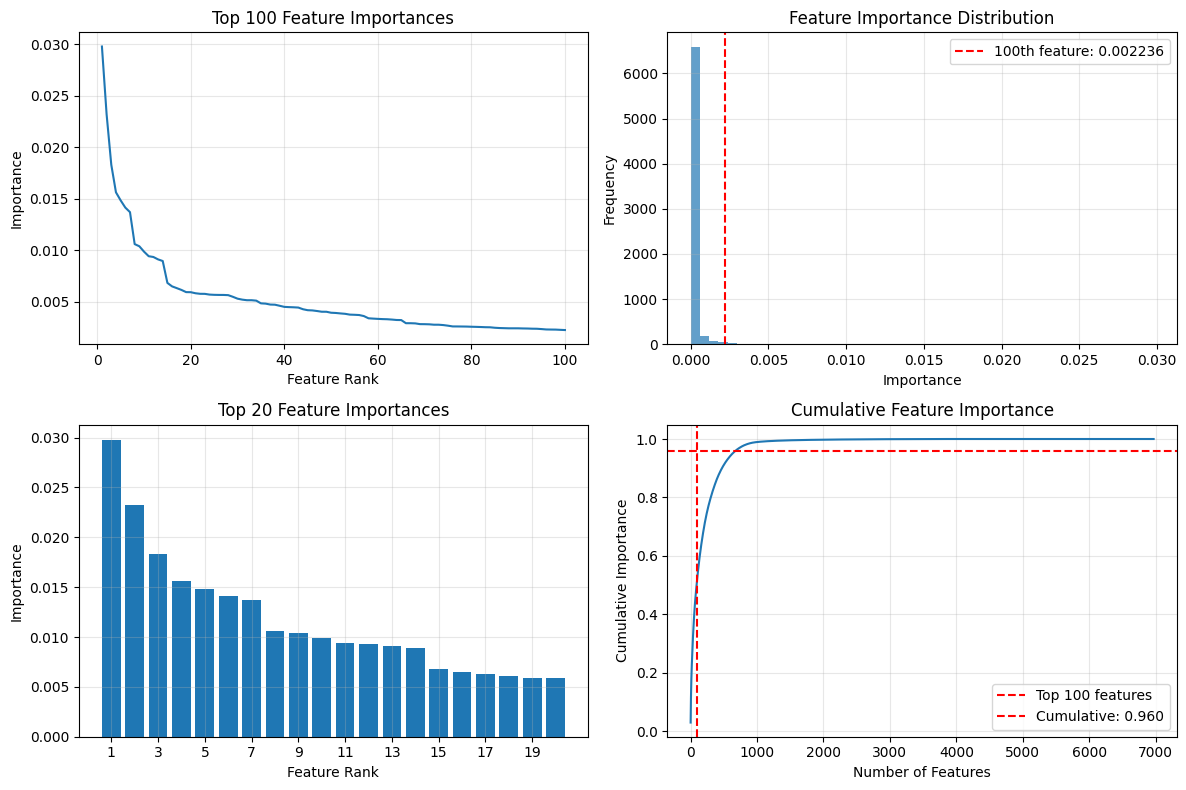

In [31]:
# Visualize feature importance distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, 101), feature_importance_df.head(100)['importance'])
plt.title('Top 100 Feature Importances')
plt.xlabel('Feature Rank')
plt.ylabel('Importance')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(feature_importance_df['importance'], bins=50, alpha=0.7)
plt.axvline(feature_importance_df.iloc[99]['importance'], color='red', linestyle='--', 
           label=f'100th feature: {feature_importance_df.iloc[99]["importance"]:.6f}')
plt.title('Feature Importance Distribution')
plt.xlabel('Importance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.bar(range(1, 21), feature_importance_df.head(20)['importance'])
plt.title('Top 20 Feature Importances')
plt.xlabel('Feature Rank')
plt.ylabel('Importance')
plt.xticks(range(1, 21, 2))
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
cumulative_importance = np.cumsum(feature_importance_df['importance'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
plt.axvline(100, color='red', linestyle='--', label='Top 100 features')
plt.axhline(cumulative_importance[99], color='red', linestyle='--', 
           label=f'Cumulative: {cumulative_importance[99]:.3f}')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
df_training_important.head()

,41401,3314,430,99663,78039,431,V290,GENDER,V053,42731,...,42789,51882,5845,77081,4373,042,73300,V1011,0549,CLASSIFIER
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style="color: yellow;">Handle Testing Dataset</h2>
<p style="color: yellow;">The main idea of this section is that the positive samples ("CLASSIFIER" == 1) are extracted and combined with multiple sizes of negative samples ("CLASSIFIER" == 1) in order to test the model performance under the condition of balanced and imbalanced testing datasets.</p>

In [36]:
# Separate positive and negative samples
positive_samples = df_testing_7382[df_testing_7382['CLASSIFIER'] == 1]
negative_samples = df_testing_7382[df_testing_7382['CLASSIFIER'] == 0]

len(positive_samples)

34

In [37]:
# Extract samples from negative_samples that at least 10 of the top-100 most important features has a value of 1
def extract_negatives_with_topk_ones(negative_samples: pd.DataFrame,
                                     top_100_features,
                                     k: int = 10) -> pd.DataFrame:
    """
    Keep rows where at least k of the top-100 features == 1 (or True).
    - negative_samples: DataFrame with 0/1 (or bool) feature columns
    - top_100_features: iterable of feature names (list/Index)
    - k: threshold count (default 10)
    """
    cols = [c for c in top_100_features if c in negative_samples.columns]
    if not cols:
        return negative_samples.iloc[0:0].copy()

    sub = negative_samples[cols]
    # Count how many of the selected features are 1/True in each row
    hits = (sub.eq(1) | sub.eq(True)).sum(axis=1)
    return negative_samples.loc[hits >= k].copy()

# Example
selected_10plus = extract_negatives_with_topk_ones(negative_samples, top_100_features, k=10)
print(selected_10plus.shape)

(498, 6970)


In [113]:
# Extract samples from negative_samples that at least 2 of the top-100 most important features has a value of 1
def extract_negatives_with_topk_ones(negative_samples: pd.DataFrame,
                                     top_100_features,
                                     k: int = 1) -> pd.DataFrame:
    """
    Keep rows where at least k of the top-100 features == 1 (or True).
    - negative_samples: DataFrame with 0/1 (or bool) feature columns
    - top_100_features: iterable of feature names (list/Index)
    - k: threshold count (default 10)
    """
    cols = [c for c in top_100_features if c in negative_samples.columns]
    if not cols:
        return negative_samples.iloc[0:0].copy()

    sub = negative_samples[cols]
    # Count how many of the selected features are 1/True in each row
    hits = (sub.eq(1) | sub.eq(True)).sum(axis=1)
    return negative_samples.loc[hits >= k].copy()

# Example
selected_3plus = extract_negatives_with_topk_ones(negative_samples, top_100_features, k=1)
print(selected_3plus.shape)

(7238, 6970)


In [114]:
# Create and shuffle in one step
df_testing_68_sim = pd.concat([positive_samples, selected_3plus.sample(n=34, random_state=42)], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_testing_68 = pd.concat([positive_samples, negative_samples.sample(n=34, random_state=42)], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_testing_340 = pd.concat([positive_samples, negative_samples.sample(n=306, random_state=42)], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_testing_680 = pd.concat([positive_samples, negative_samples.sample(n=646, random_state=42)], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_testing_1020 = pd.concat([positive_samples, negative_samples.sample(n=986, random_state=42)], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

In [40]:
print(df_testing_68_sim.shape)
print(df_testing_68.shape)
print(df_testing_340.shape)
print(df_testing_680.shape)
print(df_testing_1020.shape)

(68, 6970)
(68, 6970)
(340, 6970)
(680, 6970)
(1020, 6970)


In [41]:
# Check duplicate column names after concatenation
duplicate_columns_testing_68 = df_testing_68.columns[df_testing_68.columns.duplicated()].unique()
duplicate_columns_testing_68_sim = df_testing_68_sim.columns[df_testing_68_sim.columns.duplicated()].unique()

print(f'Number of duplicate_columns_testing_68: {duplicate_columns_testing_68}')
print(f'Number of duplicate_columns_testing_68_sim: {duplicate_columns_testing_68_sim}')

Number of duplicate_columns_testing_68: Index([], dtype='object')
Number of duplicate_columns_testing_68_sim: Index([], dtype='object')


In [42]:
#####################################################################################################

<h2 style="color: yellow;">Model Training</h2>
<p style="color: yellow;">1. Random Forest, LightGBM and DNN are trained with balanced dataset respectively<br>2. After training, we are able to get based models and "ouf of fold" data that are used on "meta model" for Ensemble Learning.</p>

In [43]:
# Train Random Forest model
def train_RF(df, batch_size=64, n_splits=5, n_estimators=500):

    # Separate features and target variable
    X = df.drop('CLASSIFIER', axis=1).values
    y = df['CLASSIFIER'].values

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {'AUC': [], 'Sensitivity': [], 'Specificity': [], 'PPV': [], 'NPV': [], 'F1-score': []}

    fold_number = 1
    fpr_list = []
    tpr_list = []

    # Placeholder for out-of-fold predictions
    oof_preds = np.zeros(X.shape[0])
    
    # Print the training dataset size
    print(f"Training Random Forest with {X.shape[0]} samples:")

    for train_index, test_index in skf.split(X, y):
        df_name = [name for name, val in globals().items() if val is df][0]  # Extract df's variable name

        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Convert data to numpy arrays
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)

        # Define and train Random Forest model
        model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
        model.fit(X_train, y_train)

        # Predictions
        y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to predictions

        # Save OOF predictions in the correct indices
        oof_preds[test_index] = y_pred_probs
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_probs)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
        f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan

        # Append metrics for the fold
        metrics['AUC'].append(auc)
        metrics['Sensitivity'].append(sensitivity)
        metrics['Specificity'].append(specificity)
        metrics['PPV'].append(ppv)
        metrics['NPV'].append(npv)
        metrics['F1-score'].append(f1)

        # Collect data for plotting ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

        fold_number += 1

    # Calculate mean and 95% CI for each metric
    def compute_mean_ci(values):
        mean = np.mean(values)
        lower = np.percentile(values, 2.5)
        upper = np.percentile(values, 97.5)
        return mean, (lower, upper)

    for metric, values in metrics.items():
        mean, ci = compute_mean_ci(values)
        print(f"{metric}: {mean:.4f} (95% CI: {ci[0]:.4f} - {ci[1]:.4f})")

    # Plot ROC curve for each fold
    plt.figure(figsize=(6, 6))
    for i in range(n_splits):
        plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {metrics["AUC"][i]:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve of {df_name} using Random Forest")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model, oof_preds

Training Random Forest with 360 samples:
AUC: 0.8649 (95% CI: 0.7827 - 0.9156)
Sensitivity: 0.7389 (95% CI: 0.6694 - 0.8056)
Specificity: 0.8333 (95% CI: 0.7806 - 0.9083)
PPV: 0.8183 (95% CI: 0.7682 - 0.8864)
NPV: 0.7635 (95% CI: 0.7165 - 0.8103)
F1-score: 0.7748 (95% CI: 0.7288 - 0.8158)


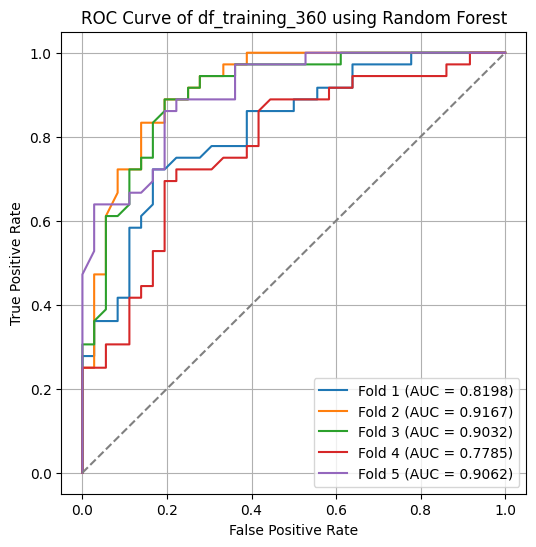

In [44]:
model_RF_360, oof_preds_RF_360 = train_RF(df_training_360)

Training Random Forest with 8180 samples:
AUC: 0.8689 (95% CI: 0.8026 - 0.9159)
Sensitivity: 0.0000 (95% CI: 0.0000 - 0.0000)
Specificity: 0.9999 (95% CI: 0.9994 - 1.0000)
PPV: nan (95% CI: nan - nan)
NPV: 0.9780 (95% CI: 0.9780 - 0.9780)
F1-score: nan (95% CI: nan - nan)


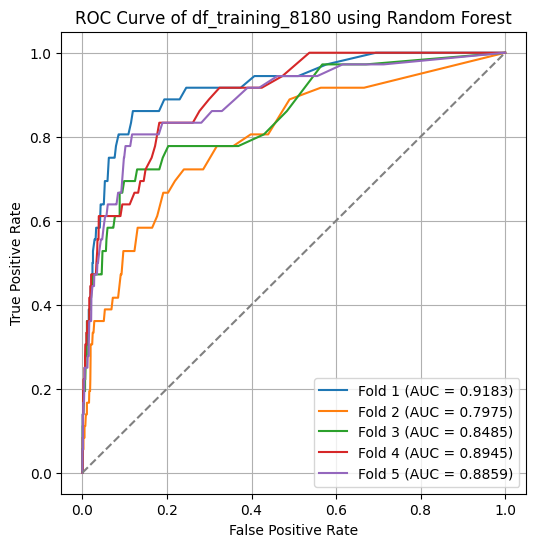

In [45]:
# Train models on different datasets
model_RF_8180, oof_preds_RF_8180 = train_RF(df_training_8180)

Training Random Forest with 39135 samples:
AUC: 0.9959 (95% CI: 0.9817 - 1.0000)
Sensitivity: 0.9556 (95% CI: 0.8944 - 0.9972)
Specificity: 0.9999 (95% CI: 0.9999 - 1.0000)
PPV: 0.9889 (95% CI: 0.9716 - 1.0000)
NPV: 0.9998 (95% CI: 0.9995 - 1.0000)
F1-score: 0.9714 (95% CI: 0.9428 - 0.9863)


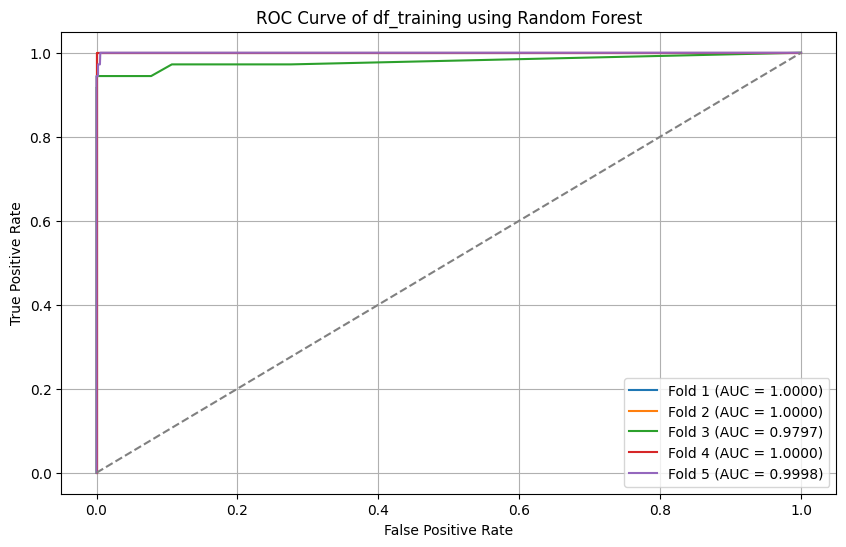

In [21]:
model_RF_39135, oof_preds_RF_39135 = train_RF(df_training)

In [129]:
# Build evaluate_model function for model training
def evaluate_model(model, df, batch_size=64):
    # Separate features and target variable
    X = df.drop('CLASSIFIER', axis=1).values
    y = df['CLASSIFIER'].values

    # Make predictions directly with scikit-learn
    y_pred_probs = model.predict_proba(X)[:, 1]  # Probability of class 1
    y_pred = (np.array(y_pred_probs) >= 0.3).astype(int)

    # Extract model's variable name from globals
    model_name = [name for name, val in globals().items() if val is model]
    if model_name:
        print(f"Evaluation on testing data with {model_name[0]}:")
    else:
        print(f"Evaluation on testing data with {model.__class__.__name__}:")

    # Calculate metrics
    metrics = {}
    metrics['AUC'] = roc_auc_score(y, y_pred_probs)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    metrics['Sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['PPV'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Calculate F1-score
    sensitivity = metrics['Sensitivity']
    ppv = metrics['PPV']
    metrics['F1'] = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

In [23]:
# Evaluate the models
print(evaluate_model(model_RF_8180, df_testing))

Evaluation on testing data with model_RF_8180:
AUC: 1.0000
Sensitivity: 0.9412
Specificity: 1.0000
PPV: 1.0000
NPV: 0.9997
F1: 0.9697
None


In [134]:
print(evaluate_model(model_RF_360, df_testing_68_sim))

Evaluation on testing data with model_RF_360:
AUC: 0.9606
Sensitivity: 1.0000
Specificity: 0.5882
PPV: 0.7083
NPV: 1.0000
F1: 0.8293
None


In [25]:
print(evaluate_model(model_RF_39135, df_testing))

Evaluation on testing data with model_RF_39135:
AUC: 1.0000
Sensitivity: 0.8235
Specificity: 1.0000
PPV: 1.0000
NPV: 0.9992
F1: 0.9032
None


In [ ]:
#########################################################################

In [46]:
# Train LightGBM model
def train_LightGBM(df, batch_size=64, n_splits=5, n_estimators=100):
    # Separate features and target variable
    X = df.drop('CLASSIFIER', axis=1).values
    y = df['CLASSIFIER'].values

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {'AUC': [], 'Sensitivity': [], 'Specificity': [], 'PPV': [], 'NPV': [], 'F1-score': []}

    fold_number = 1
    fpr_list = []
    tpr_list = []

    oof_preds = np.zeros(X.shape[0])

    print(f"Training LightGBM with {X.shape[0]} samples:")

    for train_index, test_index in skf.split(X, y):
        df_name = [name for name, val in globals().items() if val is df][0]  # Extract df's variable name

        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Convert data to numpy arrays
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)

        # Calculate class weights
        pos_weight = len(y[y==0]) / len(y[y==1])  # Ratio of negative to positive

        # Modify your model:
        model = lgb.LGBMClassifier(
            n_estimators=500,      # More trees
            learning_rate=0.02,    # Lower learning rate
            max_depth=15,          # Deeper trees
            num_leaves=120,        # More leaves
            min_child_samples=5,   # Smaller minimum samples
            subsample=0.85,        # Slight increase
            colsample_bytree=0.85, # Slight increase
            scale_pos_weight=pos_weight,
            reg_alpha=0.05,        # Lighter regularization
            reg_lambda=0.05,       # Lighter regularization
            random_state=42,
            verbose=-1,
            boost_from_average=False,  # Sometimes helps with imbalanced data
            bagging_freq=5,        # Bagging frequency
            feature_fraction=0.8   # Feature sampling
        )
        model.fit(X_train, y_train)

        # Predictions
        y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1

        # Advanced threshold optimization
        y_pred = (y_pred_probs >= 0.5).astype(int)

        oof_preds[test_index] = y_pred_probs

        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_probs)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

        # Calculate F1-score
        f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan

        # Append metrics for the fold
        metrics['AUC'].append(auc)
        metrics['Sensitivity'].append(sensitivity)
        metrics['Specificity'].append(specificity)
        metrics['PPV'].append(ppv)
        metrics['NPV'].append(npv)
        metrics['F1-score'].append(f1)

        # Collect data for plotting ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

        fold_number += 1

    # Calculate mean and 95% CI for each metric
    def compute_mean_ci(values):
        mean = np.mean(values)
        lower = np.percentile(values, 2.5)
        upper = np.percentile(values, 97.5)
        return mean, (lower, upper)

    for metric, values in metrics.items():
        mean, ci = compute_mean_ci(values)
        print(f"{metric}: {mean:.4f} (95% CI: {ci[0]:.4f} - {ci[1]:.4f})")

    # Calculate and display average F1-score
    avg_f1 = np.mean(metrics['F1-score'])
    print(f"F1-Score Across Folds: {avg_f1:.4f}")

    # Plot ROC curve for each fold
    plt.figure(figsize=(6, 6))
    for i in range(n_splits):
        plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {metrics["AUC"][i]:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve of {df_name} using LightGBM")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model, oof_preds

Training LightGBM with 360 samples:
AUC: 0.8282 (95% CI: 0.7507 - 0.8744)
Sensitivity: 0.7444 (95% CI: 0.6444 - 0.8528)
Specificity: 0.7389 (95% CI: 0.6694 - 0.8250)
PPV: 0.7433 (95% CI: 0.7116 - 0.7895)
NPV: 0.7485 (95% CI: 0.6990 - 0.8220)
F1-score: 0.7407 (95% CI: 0.7084 - 0.7830)
F1-Score Across Folds: 0.7407


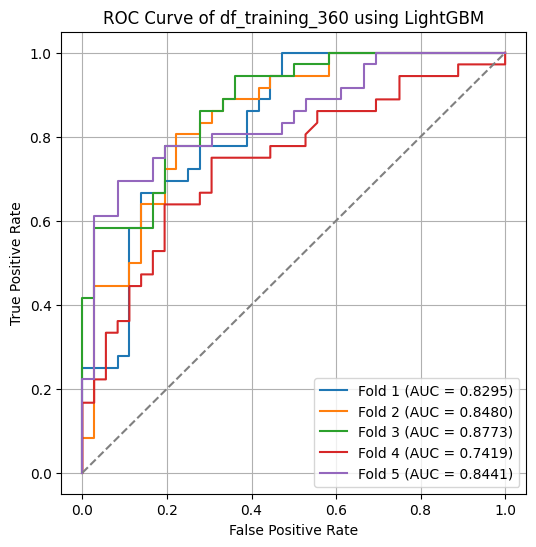

In [47]:
model_LGBM_360, oof_preds_LGBM_360 = train_LightGBM(df_training_360)

Training LightGBM with 8180 samples:
AUC: 0.7941 (95% CI: 0.7673 - 0.8223)
Sensitivity: 0.2944 (95% CI: 0.0972 - 0.4139)
Specificity: 0.9689 (95% CI: 0.9622 - 0.9764)
PPV: 0.1680 (95% CI: 0.0811 - 0.2477)
NPV: 0.9839 (95% CI: 0.9796 - 0.9866)
F1-score: 0.2126 (95% CI: 0.0879 - 0.3094)
F1-Score Across Folds: 0.2126


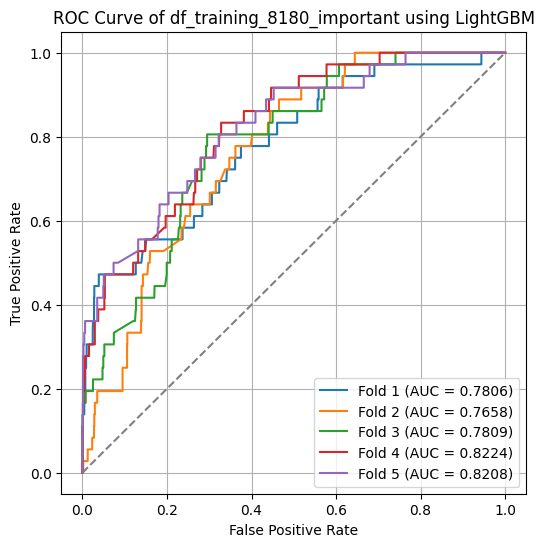

In [39]:
# Train LightGBM models on different datasets
model_LGBM_8180, oof_preds_LGBM_8180 = train_LightGBM(df_training_8180)

Training LightGBM with 39135 samples:
AUC: 0.9841 (95% CI: 0.9713 - 0.9981)
Sensitivity: 0.9167 (95% CI: 0.8611 - 0.9694)
Specificity: 0.9999 (95% CI: 0.9998 - 1.0000)
PPV: 0.9826 (95% CI: 0.9469 - 1.0000)
NPV: 0.9996 (95% CI: 0.9994 - 0.9999)
F1-score: 0.9478 (95% CI: 0.9131 - 0.9845)
F1-Score Across Folds: 0.9478


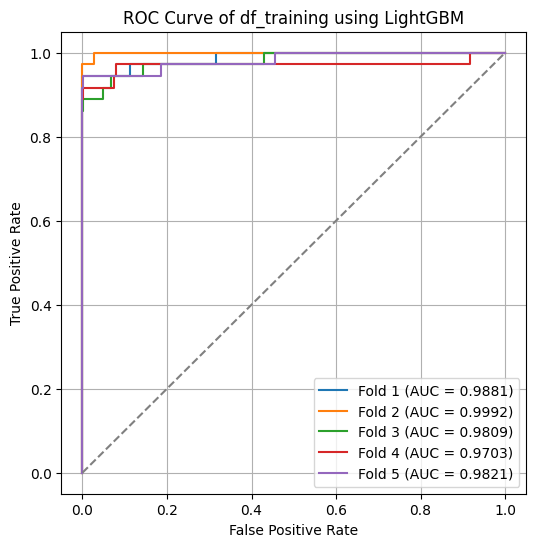

In [68]:
model_LGBM_39135, oof_preds_LGBM_39315 = train_LightGBM(df_training)

In [66]:
# Evaluate LightGBM models
print(evaluate_model(model_LGBM_8180, df_testing))

Evaluation on testing data with model_LGBM_8180:
AUC: 0.9984
Sensitivity: 0.9412
Specificity: 0.9999
PPV: 0.9697
NPV: 0.9997
F1: 0.9552
None


In [69]:
print(evaluate_model(model_LGBM_360, df_testing))

Evaluation on testing data with model_LGBM_360:
AUC: 0.9959
Sensitivity: 0.9706
Specificity: 0.9420
PPV: 0.0719
NPV: 0.9999
F1: 0.1339
None


In [70]:
print(evaluate_model(model_LGBM_39135, df_testing))

Evaluation on testing data with model_LGBM_39135:
AUC: 0.9993
Sensitivity: 0.9412
Specificity: 1.0000
PPV: 1.0000
NPV: 0.9997
F1: 0.9697
None


In [ ]:
#######################################################################################

In [48]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [49]:
# Train DNN model
def train_dnn(df, epochs=250, batch_size=32, n_splits=5, learning_rate=0.003):
    # Separate features and target variable
    X = df.drop('CLASSIFIER', axis=1).values
    y = df['CLASSIFIER'].values

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {'AUC': [], 'Sensitivity': [], 'Specificity': [], 'PPV': [], 'NPV': [], 'F1-score': []}

    fold_number = 1
    all_y_true = []
    all_y_pred_probs = []
    fpr_list = []
    tpr_list = []

    oof_preds = np.zeros(X.shape[0])
    
    print(f"Training DNN with {X.shape[0]} samples:")

    for train_index, test_index in skf.split(X, y):
        df_name = [name for name, val in globals().items() if val is df][0]  # Extract df's variable name

        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test = torch.tensor(y_test, dtype=torch.long).to(device)

        # Create TensorDatasets and DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the DNN model
        input_size = X_train.shape[1]
        model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        ).to(device)

        # Calculate class weights for imbalanced dataset
        class_counts = np.bincount(y_train.cpu().numpy())
        class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1] * 0.8], dtype=torch.float32).to(device)

        # Define loss function and optimizer with class weights
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            scheduler.step()

        # Evaluation for the fold
        with torch.no_grad():
            model.eval()
            y_true = []
            y_pred_probs = []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
                y_pred_probs.extend(probs)
                y_true.extend(labels.cpu().numpy())

            y_pred = (np.array(y_pred_probs) >= 0.5).astype(int)  # Convert probabilities to predictions

            oof_preds[test_index] = y_pred_probs

            # Calculate metrics
            auc = roc_auc_score(y_true, y_pred_probs)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
            npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
            accuracy = accuracy_score(y_true, y_pred)

            # Calculate F1-score
            f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan

            # Append metrics for the fold
            metrics['AUC'].append(auc)
            metrics['Sensitivity'].append(sensitivity)
            metrics['Specificity'].append(specificity)
            metrics['PPV'].append(ppv)
            metrics['NPV'].append(npv)
            metrics['F1-score'].append(f1)  # Add F1-score to metrics

            # Collect data for plotting ROC curve
            fpr, tpr, _ = roc_curve(y_test.cpu().numpy(), y_pred_probs)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

            fold_number += 1

    # Calculate mean and 95% CI for each metric
    def compute_mean_ci(values):
        mean = np.mean(values)
        lower = np.percentile(values, 2.5)
        upper = np.percentile(values, 97.5)
        return mean, (lower, upper)

    for metric, values in metrics.items():
        mean, ci = compute_mean_ci(values)
        print(f"{metric}: {mean:.4f} (95% CI: {ci[0]:.4f} - {ci[1]:.4f})")

    # Calculate and display average F1-score
    avg_f1 = np.mean(metrics['F1-score'])

    # Plot ROC curve for each fold
    plt.figure(figsize=(6, 6))
    for i in range(n_splits):
        plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {metrics["AUC"][i]:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve of {df_name} using DNN")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model, oof_preds

Training DNN with 360 samples:
AUC: 0.8249 (95% CI: 0.7888 - 0.8648)
Sensitivity: 0.7389 (95% CI: 0.6694 - 0.8028)
Specificity: 0.7611 (95% CI: 0.6972 - 0.8556)
PPV: 0.7582 (95% CI: 0.7109 - 0.8411)
NPV: 0.7456 (95% CI: 0.7032 - 0.7942)
F1-score: 0.7471 (95% CI: 0.7054 - 0.8078)


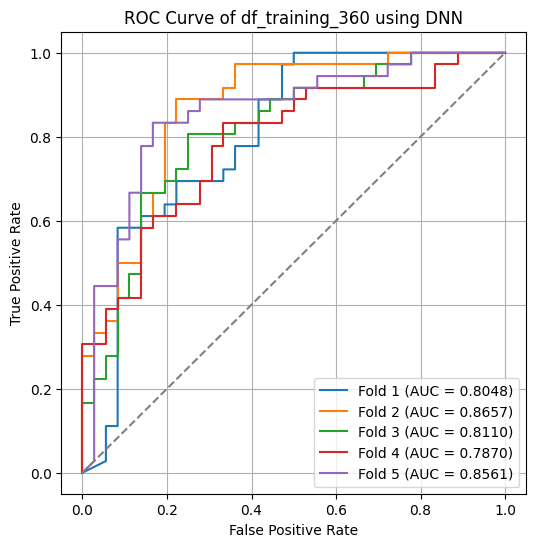

In [50]:
model_DNN_360, oof_preds_DNN_360 = train_dnn(df_training_360)

Training DNN with 8180 samples:
AUC: 0.7261 (95% CI: 0.6509 - 0.8340)
Sensitivity: 0.1000 (95% CI: 0.0583 - 0.1611)
Specificity: 0.9944 (95% CI: 0.9901 - 0.9974)
PPV: 0.3208 (95% CI: 0.1398 - 0.4429)
NPV: 0.9800 (95% CI: 0.9791 - 0.9813)
F1-score: 0.1469 (95% CI: 0.0826 - 0.2040)


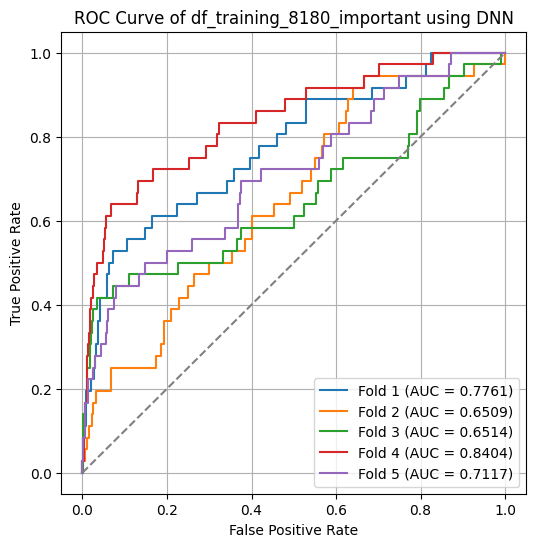

In [64]:
# Train DNN models on different datasets
model_DNN_8180, oof_preds_DNN_8180 = train_dnn(df_training_8180)

Training DNN with 39135 samples:
AUC: 0.9635 (95% CI: 0.9067 - 0.9962)
Sensitivity: 0.8500 (95% CI: 0.8056 - 0.8889)
Specificity: 0.9998 (95% CI: 0.9994 - 1.0000)
PPV: 0.9484 (95% CI: 0.8664 - 1.0000)
NPV: 0.9993 (95% CI: 0.9991 - 0.9995)
F1-score: 0.8950 (95% CI: 0.8629 - 0.9372)


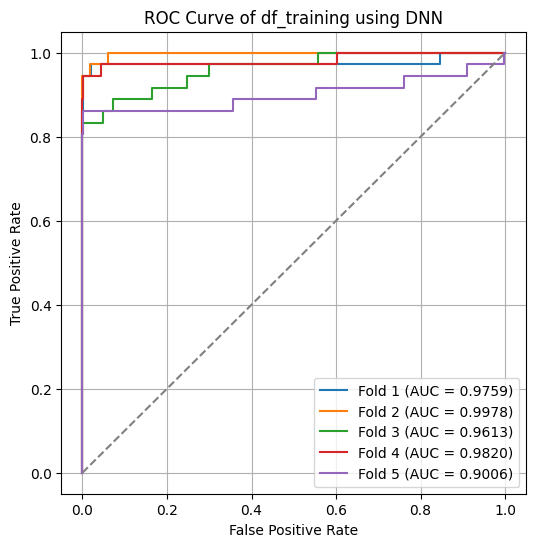

In [43]:
model_DNN_39135, oof_preds_DNN_39135 = train_dnn(df_training)

In [74]:
from torch.utils.data import TensorDataset, DataLoader

In [75]:
# Build evaluate_model function for DNN models
def evaluate_model(model, df, batch_size=64, threshold=0.1):
    # Separate features and target variable
    X = df.drop('CLASSIFIER', axis=1).values
    y = df['CLASSIFIER'].values

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.long).to(device)
    
    # Create DataLoader
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Make predictions with PyTorch model
    model.eval()
    y_pred_probs = []
    y_true = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
            y_pred_probs.extend(probs)
            y_true.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    y_pred_probs = np.array(y_pred_probs)
    y_true = np.array(y_true)
    
    # Apply threshold for predictions
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Extract model's variable name from globals
    model_name = [name for name, val in globals().items() if val is model]
    if model_name:
        print(f"Evaluation on testing data with {model_name[0]}:")
    else:
        print(f"Evaluation on testing data with {model.__class__.__name__}:")

    # Calculate metrics
    metrics = {}
    metrics['AUC'] = roc_auc_score(y, y_pred_probs)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    metrics['Sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['PPV'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Calculate F1-score
    sensitivity = metrics['Sensitivity']
    ppv = metrics['PPV']
    metrics['F1'] = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

    # Print metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

In [76]:
# Evaluate DNN models
print(evaluate_model(model_DNN_8180, df_testing))

Evaluation on testing data with model_DNN_8180:
AUC: 0.9973
Sensitivity: 0.9118
Specificity: 0.9986
PPV: 0.7561
NPV: 0.9996
F1: 0.8267
None


In [44]:
print(evaluate_model(model_DNN_360, df_testing))

Evaluation on testing data with model_DNN_360:
AUC: 0.9865
Sensitivity: 1.0000
Specificity: 0.8729
PPV: 0.0351
NPV: 1.0000
F1: 0.0679
None


In [45]:
print(evaluate_model(model_DNN_39135, df_testing))

Evaluation on testing data with model_DNN_39135:
AUC: 0.9730
Sensitivity: 0.8529
Specificity: 0.9997
PPV: 0.9355
NPV: 0.9993
F1: 0.8923
None


In [ ]:
########################################################################################

In [ ]:
# Conduct ensemble learning with 8180 and 360 samples

In [51]:
# For 360
# X = meta-feature matrix (3 columns: RF, LGBM, DNN predictions)
oof_preds_X_360 = np.column_stack([oof_preds_RF_360, oof_preds_LGBM_360, oof_preds_DNN_360])

# y = true labels for training data
y_meta_360 = df_training_360['CLASSIFIER'].values

In [52]:
# Train the LR meta-learner for 360
meta_model_LR_360 = LogisticRegression(class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=1000)
meta_model_LR_360.fit(oof_preds_X_360, y_meta_360)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [115]:
# Prepare test features and labels
X_test_7382 = df_testing_7382.drop('CLASSIFIER', axis=1).values
X_test_68 = df_testing_68.drop('CLASSIFIER', axis=1).values
X_test_68_sim = df_testing_68_sim.drop('CLASSIFIER', axis=1).values
X_test_340 = df_testing_340.drop('CLASSIFIER', axis=1).values
X_test_680 = df_testing_680.drop('CLASSIFIER', axis=1).values
X_test_1020 = df_testing_1020.drop('CLASSIFIER', axis=1).values

y_test_7382 = df_testing_7382['CLASSIFIER'].values
y_test_68 = df_testing_68['CLASSIFIER'].values
y_test_68_sim = df_testing_68_sim['CLASSIFIER'].values
y_test_340 = df_testing_340['CLASSIFIER'].values
y_test_680 = df_testing_680['CLASSIFIER'].values
y_test_1020 = df_testing_1020['CLASSIFIER'].values

In [116]:
# Predict probabilities from 360 model
test_preds_RF_360_7382 = model_RF_360.predict_proba(X_test_7382)[:, 1]
test_preds_RF_360_68 = model_RF_360.predict_proba(X_test_68)[:, 1]
test_preds_RF_360_68_sim = model_RF_360.predict_proba(X_test_68_sim)[:, 1]
test_preds_RF_360_340 = model_RF_360.predict_proba(X_test_340)[:, 1]
test_preds_RF_360_680 = model_RF_360.predict_proba(X_test_680)[:, 1]
test_preds_RF_360_1020 = model_RF_360.predict_proba(X_test_1020)[:, 1]

test_preds_LGBM_360_7382 = model_LGBM_360.predict_proba(X_test_7382)[:, 1]
test_preds_LGBM_360_68 = model_LGBM_360.predict_proba(X_test_68)[:, 1]
test_preds_LGBM_360_68_sim = model_LGBM_360.predict_proba(X_test_68_sim)[:, 1]
test_preds_LGBM_360_340 = model_LGBM_360.predict_proba(X_test_340)[:, 1]
test_preds_LGBM_360_680 = model_LGBM_360.predict_proba(X_test_680)[:, 1]
test_preds_LGBM_360_1020 = model_LGBM_360.predict_proba(X_test_1020)[:, 1]

In [117]:
# For 360 DNNs, run forward pass and extract softmax scores
X_test_tensor_7382 = torch.tensor(X_test_7382, dtype=torch.float32).to(device)
X_test_tensor_68 = torch.tensor(X_test_68, dtype=torch.float32).to(device)
X_test_tensor_68_sim = torch.tensor(X_test_68_sim, dtype=torch.float32).to(device)
X_test_tensor_340 = torch.tensor(X_test_340, dtype=torch.float32).to(device)
X_test_tensor_680 = torch.tensor(X_test_680, dtype=torch.float32).to(device)
X_test_tensor_1020 = torch.tensor(X_test_1020, dtype=torch.float32).to(device)


model_DNN_360.eval()
with torch.no_grad():
    DNN_logits_360_7382 = model_DNN_360(X_test_tensor_7382)
    DNN_logits_360_68 = model_DNN_360(X_test_tensor_68)
    DNN_logits_360_68_sim = model_DNN_360(X_test_tensor_68_sim)
    DNN_logits_360_340 = model_DNN_360(X_test_tensor_340)
    DNN_logits_360_680 = model_DNN_360(X_test_tensor_680)
    DNN_logits_360_1020 = model_DNN_360(X_test_tensor_1020)

    test_preds_DNN_360_7382 = torch.softmax(DNN_logits_360_7382, dim=1)[:, 1].cpu().numpy()
    test_preds_DNN_360_68 = torch.softmax(DNN_logits_360_68, dim=1)[:, 1].cpu().numpy()
    test_preds_DNN_360_68_sim = torch.softmax(DNN_logits_360_68_sim, dim=1)[:, 1].cpu().numpy()
    test_preds_DNN_360_340 = torch.softmax(DNN_logits_360_340, dim=1)[:, 1].cpu().numpy()
    test_preds_DNN_360_680 = torch.softmax(DNN_logits_360_680, dim=1)[:, 1].cpu().numpy()
    test_preds_DNN_360_1020 = torch.softmax(DNN_logits_360_1020, dim=1)[:, 1].cpu().numpy()

In [118]:
# Stack 360 models predictions for test set
test_preds_stack_360_7382 = np.column_stack([test_preds_RF_360_7382, test_preds_LGBM_360_7382, test_preds_DNN_360_7382])
test_preds_stack_360_68 = np.column_stack([test_preds_RF_360_68, test_preds_LGBM_360_68, test_preds_DNN_360_68])
test_preds_stack_360_68_sim = np.column_stack([test_preds_RF_360_68_sim, test_preds_LGBM_360_68_sim, test_preds_DNN_360_68_sim])
test_preds_stack_360_340 = np.column_stack([test_preds_RF_360_340, test_preds_LGBM_360_340, test_preds_DNN_360_340])
test_preds_stack_360_680 = np.column_stack([test_preds_RF_360_680, test_preds_LGBM_360_680, test_preds_DNN_360_680])
test_preds_stack_360_1020 = np.column_stack([test_preds_RF_360_1020, test_preds_LGBM_360_1020, test_preds_DNN_360_1020])

In [119]:
# Predict final probabilities from 360 LR meta-model
final_probs_LR_360_7382 = meta_model_LR_360.predict_proba(test_preds_stack_360_7382)[:, 1]
final_probs_LR_360_68 = meta_model_LR_360.predict_proba(test_preds_stack_360_68)[:, 1]
final_probs_LR_360_68_sim = meta_model_LR_360.predict_proba(test_preds_stack_360_68_sim)[:, 1]
final_probs_LR_360_340 = meta_model_LR_360.predict_proba(test_preds_stack_360_340)[:, 1]
final_probs_LR_360_680 = meta_model_LR_360.predict_proba(test_preds_stack_360_680)[:, 1]
final_probs_LR_360_1020 = meta_model_LR_360.predict_proba(test_preds_stack_360_1020)[:, 1]

final_preds_LR_360_7382 = (final_probs_LR_360_7382 >= 0.5).astype(int)
final_preds_LR_360_68 = (final_probs_LR_360_68 >= 0.5).astype(int)
final_preds_LR_360_68_sim = (final_probs_LR_360_68_sim >= 0.5).astype(int)
final_preds_LR_360_340 = (final_probs_LR_360_340 >= 0.5).astype(int)
final_preds_LR_360_680 = (final_probs_LR_360_680 >= 0.5).astype(int)
final_preds_LR_360_1020 = (final_probs_LR_360_1020 >= 0.5).astype(int)

In [120]:
from sklearn.metrics import classification_report, roc_auc_score

print("Stacking Ensemble AUC:", roc_auc_score(y_test_68, final_probs_LR_360_68))
print("Stacking Ensemble AUC:", roc_auc_score(y_test_68_sim, final_probs_LR_360_68_sim))


print("Classification Report:\n", classification_report(y_test_68, final_preds_LR_360_68))
print("Classification Report:\n", classification_report(y_test_68_sim, final_preds_LR_360_68_sim))

Stacking Ensemble AUC: 0.9610726643598615
Stacking Ensemble AUC: 0.9394463667820069
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.91      0.94      0.93        34

    accuracy                           0.93        68
   macro avg       0.93      0.93      0.93        68
weighted avg       0.93      0.93      0.93        68

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        34
           1       0.84      0.94      0.89        34

    accuracy                           0.88        68
   macro avg       0.89      0.88      0.88        68
weighted avg       0.89      0.88      0.88        68



In [121]:
# Re-defining the function since kernel reset might have cleared previous definitions

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, f1_score, roc_curve
)

# Function to evaluate meta-learner with 95% CI and ROC plot
def evaluate_meta_model_with_ci(y_true, y_prob, threshold=0.1, n_bootstrap=1000, seed=42):
    np.random.seed(seed)
    y_pred = (y_prob >= threshold).astype(int)

    auc = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if tp + fp > 0 else 0
    npv = tn / (tn + fn) if tn + fn > 0 else 0
    f1 = f1_score(y_true, y_pred)

    aucs, sens, specs, ppvs, npvs, f1s = [], [], [], [], [], []

    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        y_true_bs = y_true[indices]
        y_prob_bs = y_prob[indices]
        y_pred_bs = (y_prob_bs >= threshold).astype(int)

        try:
            aucs.append(roc_auc_score(y_true_bs, y_prob_bs))
            tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_true_bs, y_pred_bs).ravel()
            sens.append(tp_b / (tp_b + fn_b))
            specs.append(tn_b / (tn_b + fp_b))
            ppvs.append(tp_b / (tp_b + fp_b) if tp_b + fp_b > 0 else 0)
            npvs.append(tn_b / (tn_b + fn_b) if tn_b + fn_b > 0 else 0)
            f1s.append(f1_score(y_true_bs, y_pred_bs))
        except:
            continue

    def ci(data):
        return np.mean(data), np.percentile(data, 2.5), np.percentile(data, 97.5)

    metrics = {
        'AUC': ci(aucs),
        'Sensitivity': ci(sens),
        'Specificity': ci(specs),
        'PPV': ci(ppvs),
        'NPV': ci(npvs),
        'F1-score': ci(f1s)
    }

    for metric, (mean, lower, upper) in metrics.items():
        print(f"{metric}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve of Stacking Meta-Learner")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return metrics


AUC: 0.9591 (95% CI: 0.9062 - 0.9954)
Sensitivity: 0.9377 (95% CI: 0.8484 - 1.0000)
Specificity: 0.9101 (95% CI: 0.8000 - 1.0000)
PPV: 0.9132 (95% CI: 0.8056 - 1.0000)
NPV: 0.9359 (95% CI: 0.8438 - 1.0000)
F1-score: 0.9242 (95% CI: 0.8525 - 0.9851)


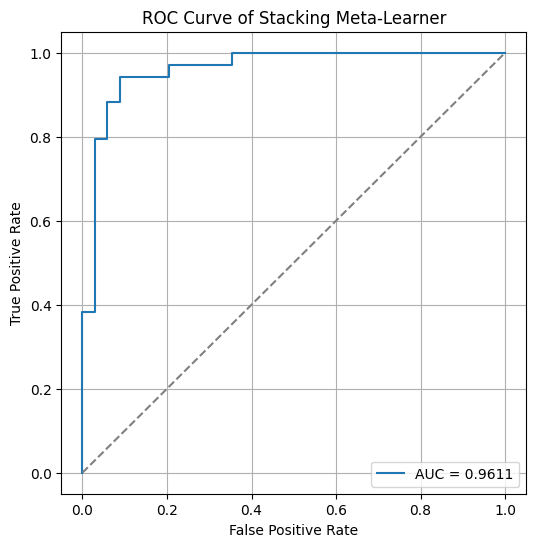

In [64]:
metrics_360_68 = evaluate_meta_model_with_ci(y_test_68, final_probs_LR_360_68, threshold=0.5)

AUC: 0.9382 (95% CI: 0.8763 - 0.9842)
Sensitivity: 0.9377 (95% CI: 0.8484 - 1.0000)
Specificity: 0.8233 (95% CI: 0.6786 - 0.9429)
PPV: 0.8414 (95% CI: 0.7143 - 0.9474)
NPV: 0.9299 (95% CI: 0.8275 - 1.0000)
F1-score: 0.8854 (95% CI: 0.8000 - 0.9524)


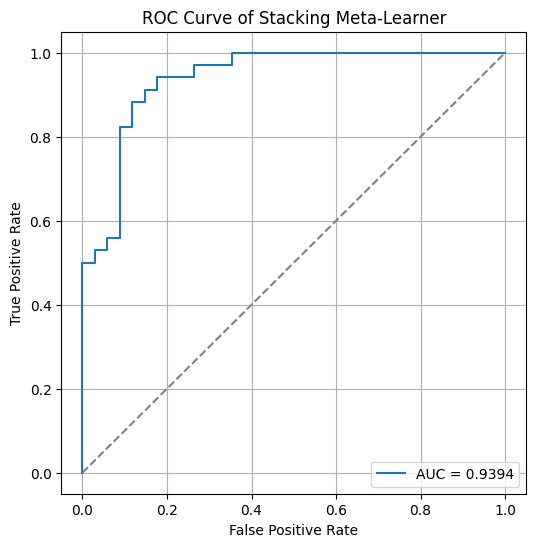

In [128]:
metrics_360_68_sim = evaluate_meta_model_with_ci(y_test_68_sim, final_probs_LR_360_68_sim, threshold=0.5)